# Homework 1
***

We are going to work with the following dataset: fluid current in a tube.
Some statistics are collected for dataset, incl. mean, skewness, kurtosis, etc. We are predicting flow rate ('tohn/hour'). We need to build confidence and predictive intervals.

In [1]:
%matplotlib inline

import numpy as np
from sklearn import datasets, linear_model, preprocessing, model_selection
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats as st
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [8]:
!ls

exxsol_data.csv  Palagashvili_hw1.ipynb


In [7]:
!wget https://raw.githubusercontent.com/dmkovalev/hamc2019/master/homeworks/exxsol_data.csv

--2023-03-22 20:42:13--  https://raw.githubusercontent.com/dmkovalev/hamc2019/master/homeworks/exxsol_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84661 (83K) [text/plain]
Saving to: ‘exxsol_data.csv’

exxsol_data.csv     100%[===================>]  82.68K  --.-KB/s    in 0.1s    

2023-03-22 20:42:14 (584 KB/s) - ‘exxsol_data.csv’ saved [84661/84661]



In [6]:
!rm exxsol_data.csv

In [10]:
df = pd.read_csv('exxsol_data.csv', sep=';', header=(0))

There are 10 features and 1 label to predict:

In [11]:
print(df.columns.values)

['mean' 'std' 'skew' 'kurt' 'RMS' 'crest' 'freq_peak' 'shan' 'perm' 'temp'
 'tohn/hour']


In [12]:
y = df['tohn/hour']
freq_temp = df[['freq_peak','temp']]

Physics tells us that flow rate is a function of a frequency peak and temperature.

In [14]:
freq_temp, y = shuffle(freq_temp, y)

from sklearn.model_selection import train_test_split
train_freq, test_freq, train_y, test_y = train_test_split(freq_temp, y, train_size=0.7, random_state=2)

lr = linear_model.LinearRegression()
predicted = model_selection.cross_val_predict(lr, freq_temp, y.ravel(), cv=20)
score = model_selection.cross_val_score(lr, freq_temp, y, scoring='r2', cv=20)

In [15]:
score

array([0.82733313, 0.88085829, 0.80281416, 0.86001148, 0.83537404,
       0.86548846, 0.92868374, 0.87432145, 0.87908234, 0.86472538,
       0.71533576, 0.71206013, 0.65611718, 0.88212949, 0.81554522,
       0.82995514, 0.8301053 , 0.82994108, 0.7488292 , 0.89428285])

## Q0: Build point estimate for mean r2 score and its deviation

In [19]:
mean = np.mean(score)
var = np.var(score, ddof=1)

_tconfint_generic(mean, np.sqrt(var), score.shape[0] - 1, 0.05, 'two-sided')

(0.6813584483607293, 0.9719409346454249)

## Q1: Predicted is an array with predictions of the label y. Assuming, that $\sigma = 0.1$, compute 95% confidence and predictive interval for mean squared error. 

In [25]:
errors = np.sqrt((predicted - y)**2)  
error_mean = np.mean(errors)
n = errors.shape[0]

confidence_interval = _zconfint_generic(error_mean, 0.1, 0.05, 'two-sided')
predictive_interval = _zconfint_generic(error_mean, (n + 1) / (10 * n), 0.05, 'two-sided')

print(f'confidence_interval = {confidence_interval}')
print(f'predictive_interval = {predictive_interval}')

confidence_interval = (0.12634830758482346, 0.5183411044928343)
predictive_interval = (0.12606831272988916, 0.5186210993477686)


## Q2:  Compute 95% confidence and predicted intervals for mean squared error, assuming no knowledge about $\sigma$.

In [26]:
errors = np.sqrt((predicted - y)**2)  
error_mean = np.mean(errors)
error_var = np.var(errors, ddof=1)
n = errors.shape[0]

confidence_interval = _tconfint_generic(error_mean, np.sqrt(error_var), n-1, 0.05, 'two-sided')
predictive_interval = _tconfint_generic(error_mean, np.sqrt(error_var) * (n+1) / n, n-1, 0.05,'two-sided')

print(f'confidence_interval = {confidence_interval}')
print(f'predictive_interval = {predictive_interval}')

confidence_interval = (-0.15909948962765658, 0.8037889017053144)
predictive_interval = (-0.15978726705003732, 0.804476679127695)


We can use additional features and more complex model, e.g. ElasticNet.

In [27]:
y = df['tohn/hour']
X = df.drop(['tohn/hour'], axis=1)
X = preprocessing.scale(X)
X, y = shuffle(X, y)

encv = linear_model.ElasticNetCV(cv=10, max_iter=3000, n_alphas=10)
predicted_encv = model_selection.cross_val_predict(encv, X, y.ravel(), cv=20)
score_encv = model_selection.cross_val_score(encv, X, y.ravel(), scoring='r2', cv=20)

## Q3:  Compute 95% confidence interval for difference in means of mean squared error between 2 models, assuming no knowledge about $\sigma$.

In [28]:
errors = np.sqrt((predicted - y)**2) 
errors_encv = np.sqrt((predicted_encv - y)**2) 

error_mean = np.mean(errors)
error_mean_encv = np.mean(errors_encv)
n = errors.shape[0]

error_var = np.var(errors, ddof=1)
error_var_encv = np.var(errors_encv, ddof=1)
var = (error_var + error_var_encv) / 2


_tconfint_generic(error_mean - error_mean_encv, np.sqrt(var), 2 * n - 2, 0.05, 'two-sided')

(-0.17530944722139463, 2.0787901285091244)

## Q4: Implement UCB1

In [33]:
class UCBModel:
    def __init__(self, prob, mean=0):
        self.prob = prob
        self.mean = mean

            
        self.size = int(mean > 0)
                
    def update(self, reward):
        self.size += 1
        self.mean = ((self.size - 1) * self.mean + reward) / self.size
    
    def __call__(self):
        return np.random.uniform(0, 1) < self.prob

num_explored: 101
num_exploited: 1899
num_best: 1487
rewards sum: 1675.0


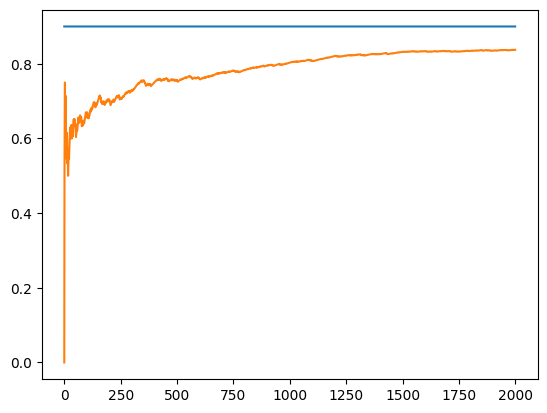

In [35]:
PROBABILITIES = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
ITRATIONS = 2000


models = [UCBModel(probability) for probability in PROBABILITIES]
rewards = np.zeros(ITRATIONS)

num_explored = 0
num_exploited = 0
num_best = 0

best_index = np.argmax([model.prob for model in models])


for i in range(ITRATIONS):
    if np.random.uniform(0, 1) < 0.05:
        num_explored += 1
        index = np.random.randint(0, len(models) - 1)
    else:
        num_exploited += 1
        index = np.argmax([
            model.mean + np.sqrt(2 * np.log(i + 1) / (model.size + 0.001))
            for model in models
        ])

    if index == best_index:
        num_best += 1

    reward = models[index]()
    rewards[i] = reward
    models[index].update(reward)

    
print(f'num_explored: {num_explored}')
print(f'num_exploited: {num_exploited}')
print(f'num_best: {num_best}')
print(f'rewards sum: {rewards.sum()}')


plt.plot(np.ones(ITRATIONS) * np.max(PROBABILITIES))
plt.plot(np.cumsum(rewards) / (np.arange(ITRATIONS) + 1))
plt.show()